In [1]:
import pandas as pd
import missingno as mgn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
# Export model
import os
import joblib
from sklearn.ensemble import RandomForestClassifier
import re

In [2]:

#* PARMAS
NEW_VERSION=True

In [3]:
df = pd.read_csv("../data/set.csv")
df.head()


,Titre,Localisation,Prix,Année-Modèle,Boite de vitesses,Type de carburant,Kilométrage,Marque,Modèle,Nombre de portes,...,Jantes aluminium,Limiteur de vitesse,Ordinateur de bord,Radar de recul,Régulateur de vitesse,Sièges cuir,Système de navigation/GPS,Toit ouvrant,Verrouillage centralisé à distance,Vitres électriques
0,Volkswagen T-Roc Diesel Automatique 2022 à Kén...,"Autre secteur, Kénitra",280 000 DH,2022,Automatique,Diesel,95 000 - 99 999,Volkswagen,T-Roc,5.0,...,False,False,False,False,False,False,False,False,False,False
1,ford kuga,"Ain Sebaa, Casablanca",196 000 DH,2018,Automatique,Diesel,130 000 - 139 999,Ford,Kuga,5.0,...,False,False,False,False,False,False,False,False,False,False
2,Dacia Duster Diesel Automatique 2021 à Casablanca,"2 Mars, Casablanca",159 000 DH,2021,Automatique,Diesel,95 000 - 99 999,Dacia,Duster,5.0,...,True,True,True,True,True,False,True,False,True,True
3,Range Rover sport autobiographie,"Californie, Casablanca",510 000 DH,2021,Automatique,Diesel,85 000 - 89 999,Land Rover,Range Rover Sport,5.0,...,True,True,True,True,True,True,True,True,True,True
4,Mercedes E220,"Zemmouri, Tanger",365 000 DH,2020,Automatique,Diesel,140 000 - 149 999,Mercedes-Benz,Classe E,5.0,...,True,True,True,True,True,True,True,True,True,True


In [4]:
df.isnull().sum()
print(f"{df.isnull().sum().sum()} Null Values")

5550 Null Values


In [5]:

# Delete unneeded Columns
df.drop(labels=["Titre","Localisation"],axis=1,inplace=True)


In [6]:

#* Rename Columns

# Assuming you have a DataFrame df with these French column names
df = df.rename(columns={
    'Prix': 'price',
    'Année-Modèle': 'model_year',
    'Boite de vitesses': 'transmission',
    'Type de carburant': 'fuel_type',
    'Kilométrage': 'mileage',
    'Marque': 'brand',
    'Modèle': 'model',
    'Nombre de portes': 'number_of_doors',
    'Origine': 'origin',
    'Première main': 'first_owner',
    'Puissance fiscale': 'tax_horsepower',
    'État': 'condition',
    'ABS': 'abs',
    'Airbags': 'airbags',
    'CD/MP3/Bluetooth': 'multimedia',
    'Caméra de recul': 'backup_camera',
    'Climatisation': 'air_conditioning',
    'ESP': 'esp',
    'Jantes aluminium': 'aluminum_wheels',
    'Limiteur de vitesse': 'speed_limiter',
    'Ordinateur de bord': 'onboard_computer',
    'Radar de recul': 'parking_sensors',
    'Régulateur de vitesse': 'cruise_control',
    'Sièges cuir': 'leather_seats',
    'Système de navigation/GPS': 'navigation_gps',
    'Toit ouvrant': 'sunroof',
    'Verrouillage centralisé à distance': 'remote_central_locking',
    'Vitres électriques': 'power_windows'
})

In [7]:
df.columns


Index(['price', 'model_year', 'transmission', 'fuel_type', 'mileage', 'brand',
       'model', 'number_of_doors', 'origin', 'first_owner', 'tax_horsepower',
       'condition', 'abs', 'airbags', 'multimedia', 'backup_camera',
       'air_conditioning', 'esp', 'aluminum_wheels', 'speed_limiter',
       'onboard_computer', 'parking_sensors', 'cruise_control',
       'leather_seats', 'navigation_gps', 'sunroof', 'remote_central_locking',
       'power_windows'],
      dtype='object')

<Axes: >

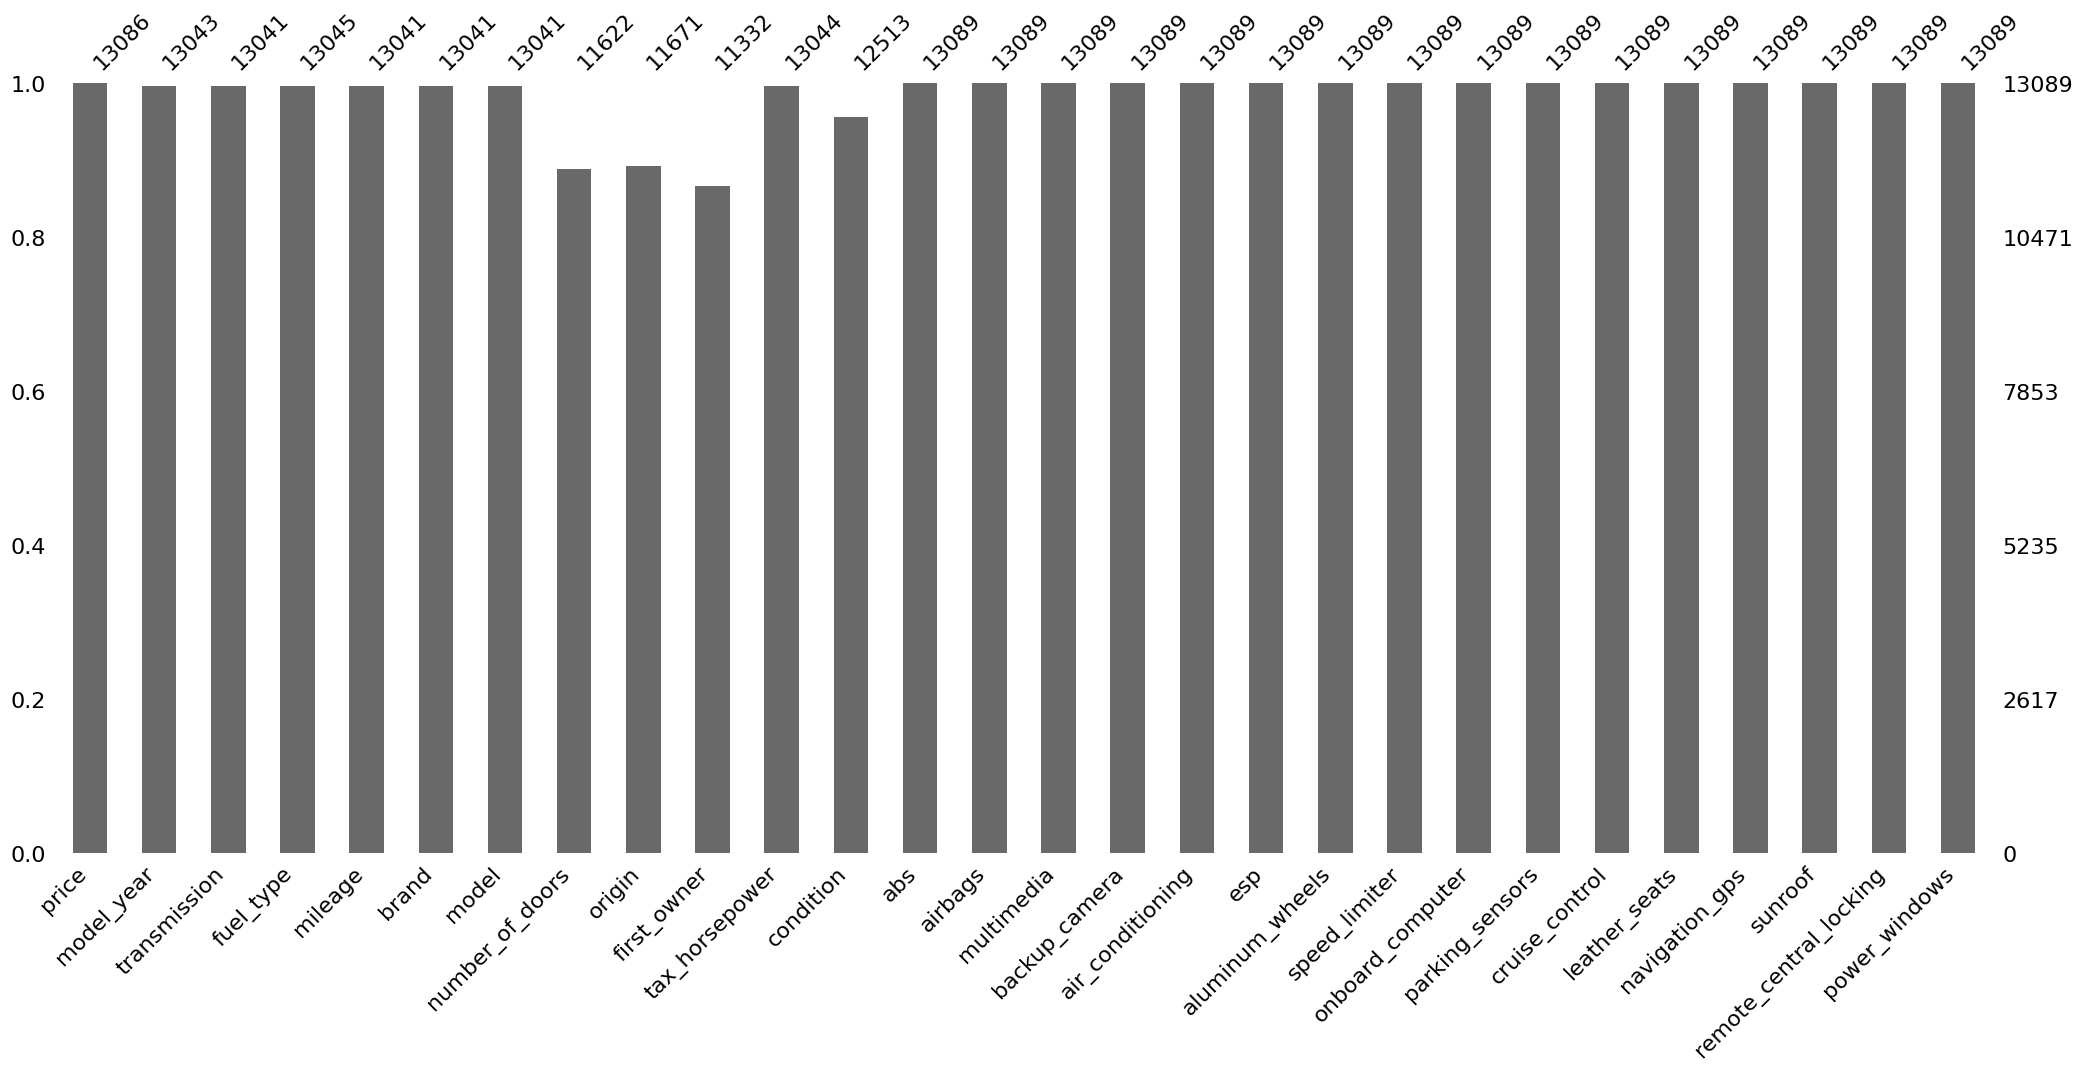

In [8]:
mgn.bar(df)

# Cleaning from Null and NaN values

### Handle Brand

In [9]:
#* Brand is null and also the other columns
#* REMOVE ALL 
df.dropna(subset=["brand"],inplace=True)


### Handle Number of Doors

In [10]:
#* All cars have doors using the mean stratigy with be good

#* transform to float to int , and null to 0
df["number_of_doors"].replace(0,np.nan)

impute_stratigy = SimpleImputer(strategy="mean")
df["number_of_doors"] = impute_stratigy.fit_transform(df["number_of_doors"].values.reshape(-1, 1))

df["number_of_doors"] = df["number_of_doors"].astype(int)

### Handle Origin

object


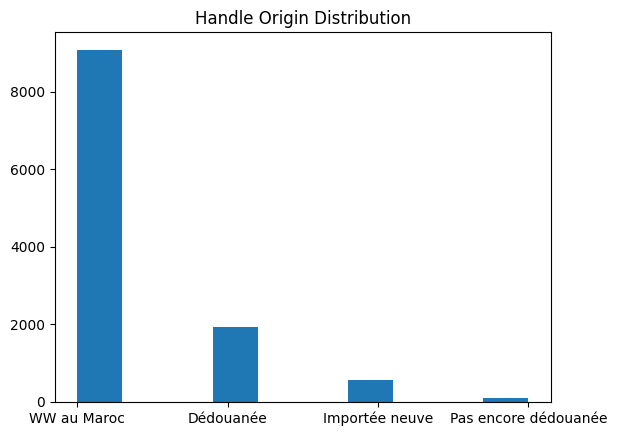

In [11]:
print(df["origin"].dtype)
#* cause the ligne with NaN in origin had other NaNs values in there extension of the reset columns 
#* I decided to remove them 

df = df[df['origin'].isin(['WW au Maroc', 'Dédouanée', 'Importée neuve','Pas encore dédouanée'])]

plt.title("Handle Origin Distribution")
plt.hist(df["origin"])
plt.show()


### Handle First Owner


['Oui' 'Non' nan]


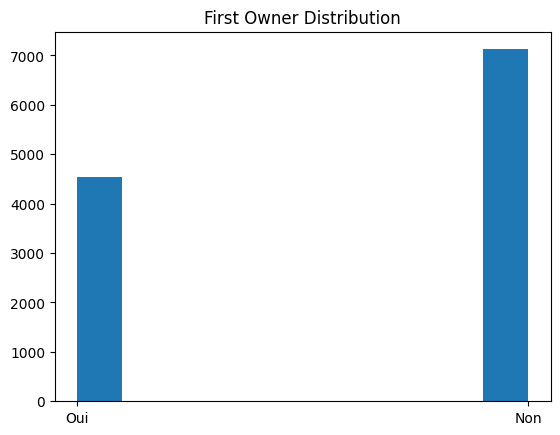

In [12]:

#* Get all the unique values 
print(df["first_owner"].unique())

#* count NaN
df["first_owner"].isna().sum()
#* If the users is not the first Owner he will not select the option 
#* the ctratigy proposed is to change all nans and nulls to Non

#* get all valid values
df["first_owner"] = df["first_owner"].where(df["first_owner"].isin(["Oui","Non"]),"Non")

#* Plot the distribution

plt.title("First Owner Distribution")
plt.hist(df["first_owner"])
plt.show()

### Handle Tax Horse Power

In [13]:
#* show the Tax horse Power Null
df = df.dropna(subset=["tax_horsepower"])

### Handle Condition

In [14]:
#* show unique values
print(df["condition"].unique())

#* as the state or condition is an important factor we delete the nan values
df = df.dropna(subset=["condition"])

['Très bon' 'Bon' 'Excellent' 'Correct' 'Neuf' nan 'Pour Pièces'
 'Endommagé']


In [15]:
print(f"Null Values: {df.isnull().sum()}")
# mgn.bar(df)

Null Values: price                     0
model_year                0
transmission              0
fuel_type                 0
mileage                   0
brand                     0
model                     0
number_of_doors           0
origin                    0
first_owner               0
tax_horsepower            0
condition                 0
abs                       0
airbags                   0
multimedia                0
backup_camera             0
air_conditioning          0
esp                       0
aluminum_wheels           0
speed_limiter             0
onboard_computer          0
parking_sensors           0
cruise_control            0
leather_seats             0
navigation_gps            0
sunroof                   0
remote_central_locking    0
power_windows             0
dtype: int64


# Price Column Analysis (Target)

In [16]:
# 1. Remove 'DH', strip spaces, handle 'NaN' strings
df["price"] = df["price"].astype(str).str.replace("DH", "").str.replace("\u202f", "").str.strip()

# 2. Convert to numeric (invalid strings become NaN)
df["price"] = pd.to_numeric(df["price"], errors='coerce')

# 3. Drop rows where 'Prix' is NaN
df.dropna(subset=["price"], inplace=True)

# 4. Convert 'Prix' to integers (if you're sure all are whole numbers)
df["price"] = df["price"].astype(int)

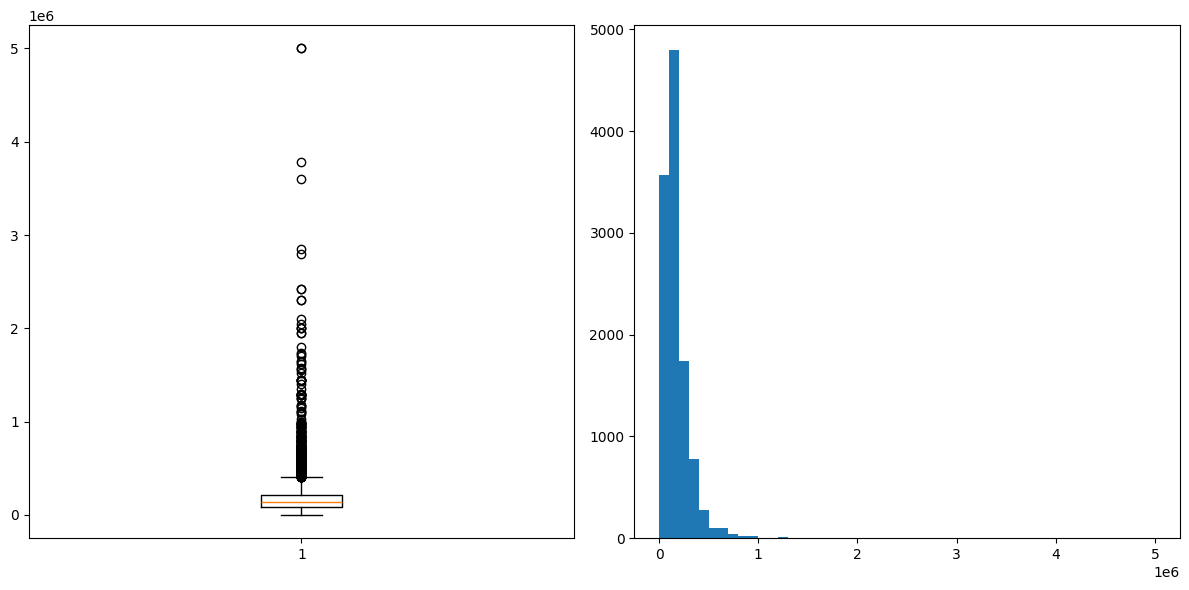

In [17]:
# Create the boxplot
figs,axes = plt.subplots(1,2,figsize=(12,6))

axes[0].boxplot(df["price"])

axes[1].hist(df["price"],bins=50)

plt.tight_layout()                 # Optional: add gridlines
plt.show()

In [18]:
Q1 = df['price'].quantile(0.25)
print("Q1 : ",Q1)
Q3 = df['price'].quantile(0.75)
print("Q3 : ",Q3)
IQR = Q3 - Q1
print("IQR : ",IQR)
lower_bound = Q1 - 1.5 * IQR
print("lower_bound : ",lower_bound)
upper_bound = Q3 + 1.5 * IQR
print("upper_bound : ",upper_bound)
outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]
print(f"Nombre de valeurs aberrantes : {len(outliers)}")

Q1 :  86000.0
Q3 :  215000.0
IQR :  129000.0
lower_bound :  -107500.0
upper_bound :  408500.0
Nombre de valeurs aberrantes : 600


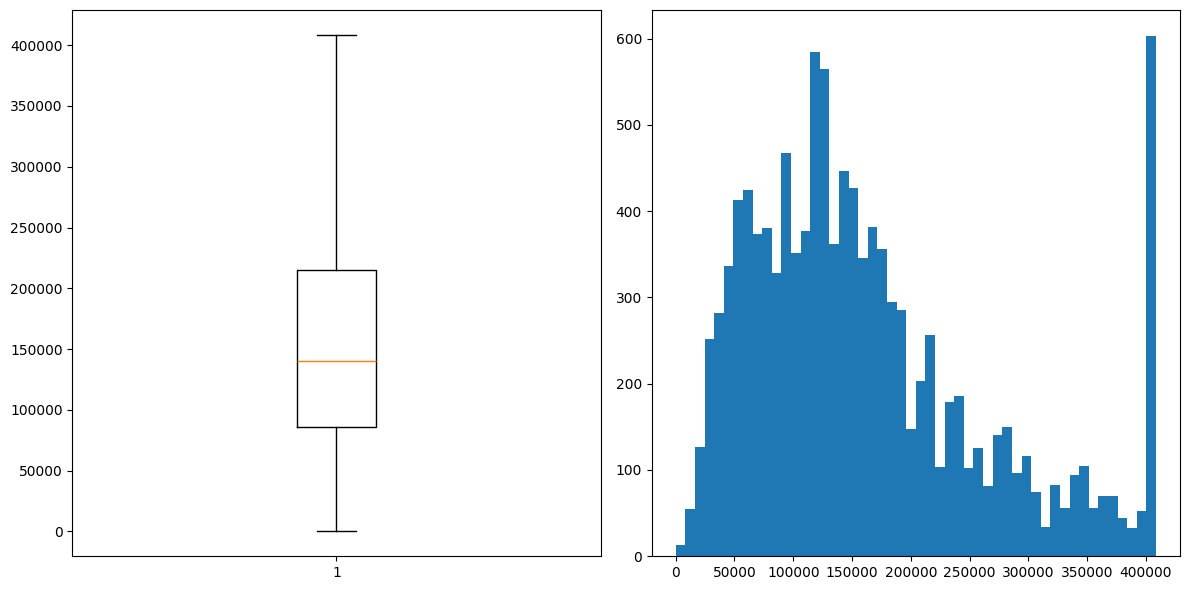

In [19]:
df['price_log'] = df['price'].clip(lower_bound, upper_bound)
######################################
#or
# Nettoyage des prix
# df['price'] = df['price'].str.replace(r"[^\d]", "", regex=True).astype(float)

# # Supprimer les valeurs aberrantes de prix
# df = df[(df['price'] > 10000) & (df['price'] < 1000000)]
# #######################################

# Create the boxplot
figs,axes = plt.subplots(1,2,figsize=(12,6))

axes[0].boxplot(df["price_log"])

axes[1].hist(df["price_log"],bins=50)

plt.tight_layout()                 # Optional: add gridlines
plt.show()

#  Netoyage du kilometrage

In [20]:
# Transformer "120 000 - 129 999" en moyenne des bornes
def mileage_to_mean(x):
    try:
        parts = x.split('-')
        return (int(parts[0].replace(' ', '')) + int(parts[1].replace(' ', ''))) / 2
    except:
        return np.nan

df['mileage'] = df['mileage'].apply(mileage_to_mean)
df['mileage'].fillna(df['mileage'].mean(), inplace=True)


C:\Users\pc\AppData\Local\Temp\ipykernel_25748\453623690.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['mileage'].fillna(df['mileage'].mean(), inplace=True)


# Conversion de modele et de horse power

In [21]:
# Année-Modèle -> int
df['model_year'] = pd.to_numeric(df['model_year'], errors='coerce')
df['model_year'].fillna(df['model_year'].median(), inplace=True)

# Puissance fiscale -> extraire valeur numérique
df['tax_horsepower'] = df['tax_horsepower'].str.extract(r"(\d+)").astype(float)
df['tax_horsepower'].fillna(df['tax_horsepower'].median(), inplace=True)


C:\Users\pc\AppData\Local\Temp\ipykernel_25748\2679056439.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['model_year'].fillna(df['model_year'].median(), inplace=True)
C:\Users\pc\AppData\Local\Temp\ipykernel_25748\2679056439.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

# L'age du voiture

In [22]:
df['car_age'] = 2025 - df['model_year']

In [23]:
# Types to pass to the model after deployment
for col in df.columns:
    print(f"{col}, {df[col].dtype}")

price, int64
model_year, float64
transmission, object
fuel_type, object
mileage, float64
brand, object
model, object
number_of_doors, int64
origin, object
first_owner, object
tax_horsepower, float64
condition, object
abs, bool
airbags, bool
multimedia, bool
backup_camera, bool
air_conditioning, bool
esp, bool
aluminum_wheels, bool
speed_limiter, bool
onboard_computer, bool
parking_sensors, bool
cruise_control, bool
leather_seats, bool
navigation_gps, bool
sunroof, bool
remote_central_locking, bool
power_windows, bool
price_log, int64
car_age, float64


# Encodage des variables categorielles

In [24]:
df = pd.get_dummies(df, columns=[
    'transmission',
    'fuel_type',
    'brand',
    'model',
    'origin',
    'condition',
    'first_owner'
], drop_first=True)


# Normalization

In [25]:

scaler = StandardScaler()
df[['price', 'mileage', 'tax_horsepower', 'car_age', 'number_of_doors']] = scaler.fit_transform(
    df[['price', 'mileage', 'tax_horsepower', 'car_age', 'number_of_doors']]
)


In [26]:
# Sélectionner uniquement les colonnes nécessaires pour éviter les problèmes lors du déploiement
target_columns = ['price', 'model_year', 'transmission', 'fuel_type', 'mileage', 'brand', 'model',
                  'number_of_doors', 'origin', 'first_owner', 'tax_horsepower', 'condition',
                  'abs', 'airbags', 'multimedia', 'backup_camera', 'air_conditioning', 'esp',
                  'aluminum_wheels', 'speed_limiter', 'onboard_computer', 'parking_sensors',
                  'cruise_control', 'leather_seats', 'navigation_gps', 'sunroof',
                  'remote_central_locking', 'power_windows']

# Filtrer le DataFrame pour ne conserver que les colonnes nécessaires
df = df[[col for col in df.columns if col in target_columns]]
print("Colonnes après filtrage :", df.columns.tolist())

Colonnes après filtrage : ['price', 'model_year', 'mileage', 'number_of_doors', 'tax_horsepower', 'abs', 'airbags', 'multimedia', 'backup_camera', 'air_conditioning', 'esp', 'aluminum_wheels', 'speed_limiter', 'onboard_computer', 'parking_sensors', 'cruise_control', 'leather_seats', 'navigation_gps', 'sunroof', 'remote_central_locking', 'power_windows']


# Separation des donnees (train | test) + Entrainement du modele

In [27]:
X = df.drop("price", axis=1)
y = df["price"]

print(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


Index(['model_year', 'mileage', 'number_of_doors', 'tax_horsepower', 'abs',
       'airbags', 'multimedia', 'backup_camera', 'air_conditioning', 'esp',
       'aluminum_wheels', 'speed_limiter', 'onboard_computer',
       'parking_sensors', 'cruise_control', 'leather_seats', 'navigation_gps',
       'sunroof', 'remote_central_locking', 'power_windows'],
      dtype='object')


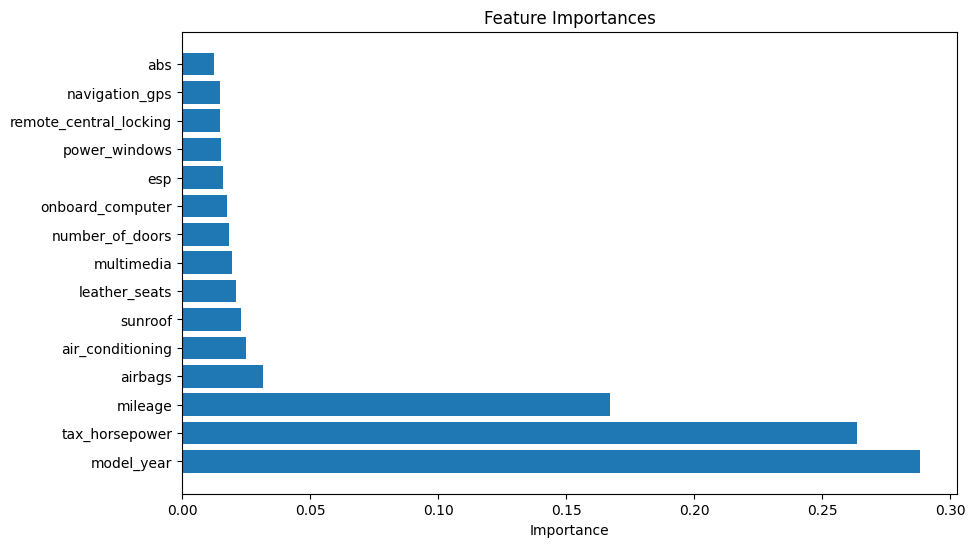

                   Feature  Importance
0               model_year    0.288221
3           tax_horsepower    0.263722
1                  mileage    0.167086
5                  airbags    0.031453
8         air_conditioning    0.025004
17                 sunroof    0.023022
15           leather_seats    0.021003
6               multimedia    0.019703
2          number_of_doors    0.018223
12        onboard_computer    0.017528
9                      esp    0.015907
19           power_windows    0.015292
18  remote_central_locking    0.015025
16          navigation_gps    0.014889
4                      abs    0.012507


In [28]:
# Get the feature importances
importances = model.feature_importances_

# Create a DataFrame to store the features and their importances
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort the features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)[0:15]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

# Print the feature importances (optional)
print(feature_importances)

In [29]:
# Directory to save models
if NEW_VERSION:
    
    MODEL_DIR = "."
    os.makedirs(MODEL_DIR, exist_ok=True)

    def get_next_model_version():
        existing_models = [f for f in os.listdir(MODEL_DIR) if re.match(r"v\d+\.pkl", f)]
        versions = [int(re.findall(r'\d+', fname)[0]) for fname in existing_models]
        next_version = max(versions) + 1 if versions else 1
        return f"v{next_version}.pkl"


    # Save with version
    model_filename = get_next_model_version()
    joblib.dump(model, os.path.join(MODEL_DIR, model_filename))
    print(f"Model saved as {model_filename}")


Model saved as v1.pkl


# Evaluation du modele 

In [30]:
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

MAE: 0.2807198255941135
R2 Score: 0.3734712672662208
